In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import statsmodels.formula.api as sm
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot as plt
%matplotlib inline

Loading the data and setting the hyperparameters

In [2]:
data = pd.read_csv('Melbourne_housing_FULL.csv')

In [3]:
data_model = pd.read_csv('meta_model.csv', index_col=False)
meta_model = DecisionTreeRegressor(random_state=1)
meta_model.fit(data_model.drop(['prediction'], axis=1), data_model['prediction'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [4]:
target_column = 'Price'

In [5]:
# hyperparameters
n_estimators = 2
lof_n_neighbors = 20
pca_n_components = 3
n_random_subset = 5
sl_backward_elimination = 0.05

In [6]:
# transform categorical variables to nominal variables
le = LabelEncoder()
data['Suburb'] = le.fit_transform(data['Suburb'])
data['Address'] = le.fit_transform(data['Address'])
data['Regionname'] = le.fit_transform([str(rn) for rn in data['Regionname']])
data['CouncilArea'] = le.fit_transform([str(ca) for ca in data['CouncilArea']])
data['SellerG'] = le.fit_transform(data['SellerG'])
data['Type'] = le.fit_transform(data['Type'])
data['Method'] = le.fit_transform(data['Method'])
data['Date'] = [int(d.split('/')[2]) for d in data['Date']]

nominal_columnnames = ['Suburb', 'Address', 'Regionname', 'CouncilArea', 'SellerG', 'Type', 'Method', 'Date']

X = data.drop([target_column], axis=1)
y = data[target_column]

In [7]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)
#data_whole = pd.concat([data_train, data_test], axis=0)

In [8]:
df_metadata = pd.DataFrame(columns=['number_of_instances', 'number_of_features', 'noise_to_signal_ratio', 
            'mean_kurtosis_of_numeric_attributes', 'mean_means_of_numeric_attributes', 
            'mean_std_dev_of_numeric_attributes', 'mean_mutual_information', 'max_nominal_att_distinct_values', 
            'mean_std_dev_nominal_att_distinct_values', 'mean_nominal_att_distinct_values', 
            'mean_skewness_of_numeric_attributes'])

Meta-learning

In [9]:
# predict the accuracy of the preprocessed training dataset with the metadata
def predict_accuracy(dataset_train):
    global df_metadata
    #X, y = getXy(dataset_train)
    metadata = getMetadata(dataset_train)
    df_metadata = df_metadata.iloc[0:0]
    df_metadata.loc[0] = metadata
    df_metadata.fillna(0, inplace=True)
    return float(meta_model.predict(df_metadata))

In [10]:
def getMetadata(dataset):
    nominal_attributes, numeric_attributes = getNumericAndNominal(dataset)
    number_of_instances = dataset.shape[0]
    number_of_features = dataset.shape[1]
    noise_to_signal_ratio = np.mean(dataset.mean(numeric_only=True)) / np.mean(dataset.std(numeric_only=True))
    mean_kurtosis_of_numeric_attributes = np.mean(numeric_attributes.kurtosis(numeric_only=True))
    mean_means_of_numeric_attributes = np.mean(numeric_attributes.mean(numeric_only=True))
    mean_std_dev_of_numeric_attributes = np.mean(numeric_attributes.std(numeric_only=True))
    mean_mutual_information = np.mean(mutual_info_regression(dataset.drop([target_column], axis=1), dataset[target_column]))
    max_nominal_att_distinct_values = np.max(nominal_attributes.nunique())
    mean_std_dev_nominal_att_distinct_values = np.mean(nominal_attributes.std())
    mean_nominal_att_distinct_values = np.mean(nominal_attributes.nunique())
    mean_skewness_of_numeric_attributes = np.mean(dataset.skew(numeric_only=True))
    return [number_of_instances, number_of_features, noise_to_signal_ratio, mean_kurtosis_of_numeric_attributes, 
           mean_means_of_numeric_attributes, mean_std_dev_of_numeric_attributes, mean_mutual_information, 
           max_nominal_att_distinct_values, mean_std_dev_nominal_att_distinct_values, mean_nominal_att_distinct_values, 
           mean_skewness_of_numeric_attributes]

In [11]:
#variables
best_score = 0
best_mcps = []
best_train_data = data_train.copy()
mcps = []
all_scores = {}

In [12]:
def update_score(dataset_train, mcps):
    global best_score, best_mcps, best_train_data, all_scores
    score = predict_accuracy(dataset_train)
    all_scores[score] = mcps
    if score > best_score:
        best_score = score
        best_mcps = mcps
        best_train_data = dataset_train.copy()

In [13]:
def getXy(dataset):
    X_data = dataset.drop([target_column], axis=1)
    y_data = dataset[target_column]
    return X_data, y_data

In [14]:
def getNumericAndNominal(dataset):
    nominal_att = dataset.loc[:, dataset.columns.isin(nominal_columnnames)]
    numeric_att = dataset.drop(nominal_columnnames, axis=1, errors='ignore')
    return nominal_att, numeric_att

Choosing the methods for datapreprocessing automatically with Meta-learning

In [15]:
# handling missing values
# drop rows with missing values
def drop_rows(data_train):
    return data_train.dropna()

# replace missing values with zero
def replace_with_zero(data_train):
    return data_train.fillna(0)

# replace missing values with mean
def replace_with_mean(data_train):
    return data_train.fillna(data_train.mean())

# replace missing values with median
def replace_with_median(data_train):
    return data_train.fillna(data_train.median())

# replace missing values with min
def replace_with_min(data_train):
    return data_train.fillna(data_train.min())

# replace missing values with max
def replace_with_max(data_train):
    return data_train.fillna(data_train.max())

In [16]:
# Outliers
# no outlier handling
def no_outlier_handling(data_train):
    return data_train

# remove outliers with Interquartile Range
def interquartile_range(data_train):
    q25_train = np.percentile(data_train[target_column], 25)
    q75_train = np.percentile(data_train[target_column], 75)
    iqr_train = data_train.drop(data_train[(data_train[target_column] < q25_train) | 
                                           (data_train[target_column] > q75_train)].index, axis=0)
    return iqr_train

# remove outliers with BaggedLOF
def bagged_lof(data_train):
    lof = LocalOutlierFactor(n_neighbors=lof_n_neighbors, contamination=0.1)
    outlier_train_pred = lof.fit_predict(data_train)
    lof_train = data_train.drop(data_train[outlier_train_pred == -1].index, axis=0)
    return lof_train

In [17]:
# Transformation
# no transformation
def no_transformation(data_train):
    return data_train

# normalization
def normalization(data_train):
    normalizer = preprocessing.Normalizer(norm='l2')
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    normalized_X_train = pd.DataFrame(normalizer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    normalized_train = pd.concat([normalized_X_train, y_train], axis=1)
    return normalized_train

# standardize
def standardization(data_train):
    standardizer = preprocessing.StandardScaler()
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    standardized_X_train = pd.DataFrame(standardizer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    standardized_train = pd.concat([standardized_X_train, y_train], axis=1)
    return standardized_train

In [18]:
# Dimensionality Reduction
# no Dimensionality Reduction
def no_reduction(data_train):
    return data_train

# PCA
def pca(data_train):
    pca = PCA(n_components=pca_n_components)
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    pca_X_train = pd.DataFrame(data=pca.fit_transform(X_train), index=X_train.index)
    pca_train = pd.concat([pca_X_train, y_train], axis=1)
    return pca_train
    
# RandomSubset
def random_subset(data_train):
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    random_X_train = X_train.sample(n_random_subset, axis=1)
    random_train = pd.concat([random_X_train, y_train], axis=1)
    return random_train

# Backward Elimination
def backward_elimination(data_train):
    X_train = data_train.drop([target_column], axis=1)
    y_train = data_train[target_column]
    numVars = X_train.shape[1]
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl_backward_elimination:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    X_train.drop([X_train.columns[j]], axis=1, inplace=True)
    be_train = pd.concat([X_train, y_train], axis=1)
    return be_train

In [19]:
# Grid-search for finding the best mcps
handling_missing_values = [drop_rows] #, replace_with_zero, replace_with_mean, replace_with_median, replace_with_min, replace_with_max
handling_outliers = [no_outlier_handling, interquartile_range, bagged_lof] #
transformations = [no_transformation, normalization, standardization] #
dimensionality_reduction = [no_reduction, pca, random_subset, backward_elimination] #
for missing_values_method in handling_missing_values:
    filled_train_data = missing_values_method(data_train)
    print(missing_values_method.__name__)
    for outlier_method in handling_outliers:
        outliers_handled_train_data = outlier_method(filled_train_data)
        for transformation_method in transformations:
            transformed_train_data = transformation_method(outliers_handled_train_data)
            for dim_reduction_method in dimensionality_reduction:
                if dim_reduction_method.__name__ == 'pca' and transformation_method.__name__ == 'no_transformation':
                    continue
                reduced_train_data = dim_reduction_method(transformed_train_data)
                if reduced_train_data.shape[1] > 1:
                    mcps = [missing_values_method.__name__, outlier_method.__name__, transformation_method.__name__,
                            dim_reduction_method.__name__]
                    update_score(reduced_train_data, mcps)

drop_rows


In [20]:
best_mcps

['drop_rows', 'no_outlier_handling', 'standardization', 'backward_elimination']

In [21]:
training_score = best_score
training_score

0.6295494885001244

In [22]:
# all_scores

testing the preprocessed dataset

In [25]:
def adj_r2(y_true, y_pred):
    R2 = metrics.r2_score(y_true, y_pred)
    n = len(y_true)
    p = best_train_data.shape[1] - 1
    return 1-(1-R2)*(n-1)/(n-p-1)

In [26]:
def make_prediction(dataset_train, dataset_test):
    X_train, y_train = getXy(dataset_train)
    X_test, y_test = getXy(dataset_test)
    #regressor = LinearRegression()
    #regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)
    pred_test = regressor.predict(X_test)
    return adj_r2(y_test, pred_test), y_test, pred_test

In [27]:
# preprocess the testset in the same way like the trainingset
data_test = locals()[best_mcps[0]](data_test)
data_test = locals()[best_mcps[1]](data_test)
data_test = locals()[best_mcps[2]](data_test)
if (best_mcps[3] == 'backward_elimination'):
    data_test = data_test[best_train_data.columns]
else:
    data_test = locals()[best_mcps[3]](data_test)

In [28]:
test_score, real_test, pred_test = make_prediction(best_train_data, data_test)
test_score

0.60895988563381453

Text(0,0.5,'Predicted Price')

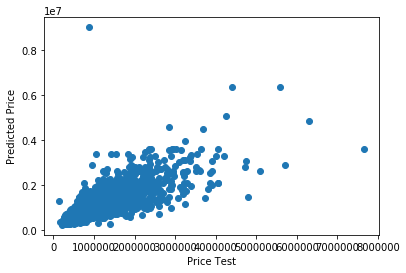

In [29]:
plt.scatter(real_test, pred_test)
plt.xlabel('Price Test')
plt.ylabel('Predicted Price')

Saving the data

In [30]:
pd.DataFrame(pred_test).to_csv('meta_pred.csv', sep=',', encoding='utf-8', index=None)
pd.DataFrame(real_test).to_csv('meta_test.csv', sep=',', encoding='utf-8', index=None)